   # **Gentrification and AirBnb in New York: Two sides of the same coin**

## Background and Context: 

AirBnb prides itself on its ability to make travel more than what it seems - it's mission is to help people feel like they _belong_ anywhere they go through more authentic cultural experiences. However, what if AirBnb's efforts to **_connect the differences_** are creating **_more_**? 

This project can also be found on the github repository at https://github.com/Lubaina97/323-Final-Project/tree/master! 

### Gentrification:

Gentrification is a general term for the arrival of wealthier people in an existing urban district, a related increase in rents and property values, and changes in the district's character and culture. The term is often used negatively, suggesting the displacement of poor communities by rich outsiders.

The economics of gentrification explicitly state that neighborhood property values increase, decreasing the supply of affordable housing available to lower-income residents who are then displaced, as the cost of living in the neighborhood increases.

### AirBnb and Gentrification:

A report titled _“The High Cost of Short-Term Rentals in New York City,”_ authored by a research group from the McGill University School of Urban Planning, found that in the study period of September 2014 through August 2017 Airbnb has potentially removed between 7,000 and 13,500 units of housing from New York’s long-term rental market, putting extra pressure on a city already squeezed for housing.

### **Project Scope:**
## Comparing geo-spatial trends in AirBnb listings and housing unit prices in New York to analyze                         a gentrification effect (2014-2017).

In [2]:
import pandas as pd
import numpy as np
import qeds
qeds.themes.mpl_style();
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
import descartes
import folium 
from folium import plugins
from folium.plugins import HeatMap

import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import geopandas as gpd
from pandas_datareader import DataReader


from shapely.geometry import Point, Polygon

%matplotlib inline
# activate plot theme

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Data Sourcing and Cleaning:

* The first set of data was collected from **The New York City Housing and Vacancy Survey (NYCHVS)**, sponsored by the New York City Department of Housing Preservation and Development. The Census Bureau has conducted the survey for the City since 1965. Detailed data from the survey cover many characteristics of the City’s housing market, including characteristics of the City’s population, households, housing stock, and neighborhoods. 

In [3]:
df = pd.read_csv('./occupied_units2017 copy.csv') # Housing data for 2017
df.head()

,Record Type,Borough,External Walls--Missing brick and sloping walls,External Walls--Major cracks in walls,External Walls--Loose or hanging cornice,External Walls--No problems,External Walls--Unable to observe,Condition of Windows--Broken/missing,Condition of Windows--Rotten/loose,Condition of Windows--Boarded-up,...,Replicate Weight #74,Replicate Weight #75,Replicate Weight #76,Replicate Weight #77,Replicate Weight #78,Replicate Weight #79,Replicate Weight #80,30% HUD Income Limits,50% HUD Income Limits,80% HUD Income Limits
0,1,1,9,9,9,1,9,9,9,9,...,37635400,33263896,10348898,11446240,32161256,9745805,13739972,21800,36250,58000
1,1,1,9,9,9,1,9,9,9,9,...,8270628,23614216,42797336,19594332,8525261,36330660,28940264,27200,45300,72500
2,1,1,9,9,9,1,9,9,9,9,...,8270628,23614216,42797336,19594332,8525261,36330660,28940264,24500,40800,65250
3,1,1,9,9,9,1,9,9,9,9,...,35934840,10027288,46175948,57167296,43401080,10664017,66729560,21800,36250,58000
4,1,1,9,9,9,1,9,9,9,9,...,50290496,10630692,32310018,70148672,42706528,10137630,64932696,21800,36250,58000


As shown above, the NYCHVS survey has several columns and thus, for the purpose of this project, I will create a subset of the above table that I will then use for my analysis.

In [4]:
subset = df.loc[:,['Borough','Sub-borough area','Race and Ethnicity of householder','Monthly gross rent','Household income recode']]
subset.head()

,Borough,Sub-borough area,Race and Ethnicity of householder,Monthly gross rent,Household income recode
0,1,1,4,99999,95000
1,1,1,3,1227,21372
2,1,1,4,1675,33000
3,1,1,4,1011,39655
4,1,1,4,99999,45952


* Checking for null values

In [5]:
print('The number of observations in this dataset are', subset.shape)
subset.isnull().sum()

The number of observations in this dataset are (13266, 5)


Borough                              0
Sub-borough area                     0
Race and Ethnicity of householder    0
Monthly gross rent                   0
Household income recode              0
dtype: int64

* The NYCHVS survey provides a code-book that has an extensive list of what the codes for each column mean. On noticing that there are no null values, I checked for the code for missing values which varied by column and hence I have dropped the observations with missing values. 

In [6]:
subset.loc[(subset['Monthly gross rent'] == 99999) | (subset['Household income recode'] == 9999999), :]

,Borough,Sub-borough area,Race and Ethnicity of householder,Monthly gross rent,Household income recode
0,1,1,4,99999,95000
4,1,1,4,99999,45952
12,1,1,2,99999,20756
24,1,1,3,99999,35700
54,1,1,3,99999,16800
...,...,...,...,...,...
13253,5,2,3,99999,179330
13254,5,2,1,99999,177000
13255,5,2,1,99999,208000
13262,5,3,1,99999,17800


In [7]:
clean_subset = subset.loc[(subset['Monthly gross rent'] == 99999) | (subset['Household income recode'] == 9999999), :]
print('The number of observations in this dataset are', clean_subset.shape)

The number of observations in this dataset are (4587, 5)


I now need to check for how many observations are going to be dropped. 

In [8]:
subset.drop(subset.loc[(subset['Monthly gross rent']==99999) | (subset['Household income recode']==9999999)].index, inplace=True)
subset.shape

(8679, 5)

In [9]:
subset = subset.sort_values(by=['Borough'])

* In order to observe gentrification in an area, we can see a reflection through the percentage increase/decrease of rent and income in the area. Additionally, since there is a strong claim that gentrification displaces people of colour from areas, we can analyze the Racial Profile of a sub borough by observing the most frequent 'Race' in the respective area.

In [10]:
# Mean and median rent in 2017 for each sub-borough

subset_grouped_rent2017 = subset.groupby(['Borough','Sub-borough area']).agg({'Monthly gross rent': ['mean', 'median']})
subset_grouped_rent2017.columns = ['Rent_Mean', 'Rent_Median']
subset_grouped_rent2017 = subset_grouped_rent2017.reset_index()

# Mean and median income in 2017 for each sub-borough

subset_grouped_income2017 = subset.groupby(['Borough','Sub-borough area']).agg({'Household income recode': ['mean', 'median']})
subset_grouped_income2017.columns = ['Income_Mean', 'Income_Median']
subset_grouped_income2017 = subset_grouped_income2017.reset_index()

# Most frequent racial code in 2017 for each sub-borough

subset_grouped_race2017 = subset.groupby(['Borough','Sub-borough area'],  as_index=False)['Race and Ethnicity of householder'].apply(lambda x: x.value_counts(dropna=False).idxmax())

* Thus, so far we have the mean and median rent and income, along with the most frequent race by each sub-borough for 2017. In order to analyze a percent change, I will need to do the same for 2014.

In [11]:
df_1 = pd.read_csv('./occupied_units2014 copy.csv') # Housing data for 2014
df_1.shape

(15342, 277)

In [12]:
subset_1 = df_1.loc[:,['Borough','Sub-borough area', 'Race and Ethnicity of householder','Monthly gross rent','Household income recode']]
subset_1.isnull().sum()

Borough                              0
Sub-borough area                     0
Race and Ethnicity of householder    0
Monthly gross rent                   0
Household income recode              0
dtype: int64

In [13]:
subset_1.drop(subset_1.loc[(subset_1['Monthly gross rent']==99999) | (subset_1['Household income recode']==9999999)].index, inplace=True)

In [14]:
subset_1 = subset_1.sort_values(by=['Borough'])

In [15]:
# Mean and median rent in 2014 for each sub-borough

subset_grouped_rent2014 = subset_1.groupby(['Borough','Sub-borough area']).agg({'Monthly gross rent': ['mean', 'median']})
subset_grouped_rent2014.columns = ['Rent_Mean', 'Rent_Median']
subset_grouped_rent2014 = subset_grouped_rent2014.reset_index()

# Mean and median income in 2014 for each sub-borough

subset_grouped_income2014 = subset_1.groupby(['Borough','Sub-borough area']).agg({'Household income recode': ['mean', 'median']})
subset_grouped_income2014.columns = ['Income_Mean', 'Income_Median']
subset_grouped_income2014 = subset_grouped_income2014.reset_index()

# Most frequent racial code in 2014 for each sub-borough

subset_grouped_race2014 = subset_1.groupby(['Borough','Sub-borough area'],  as_index=False)['Race and Ethnicity of householder'].apply(lambda x: x.value_counts(dropna=False).idxmax())

* Now that we have the rent, income and race data for New York in 2014 and 2017, we can move forward in observing the percent changes for the above to analyze a gentrification effect. 

In [11]:
# Loading income mean and medians for each sub-borough in 2014 and 2017

df1 = pd.read_csv('./subset_grouped_income2014.csv')
df2 = pd.read_csv('./subset_grouped_income2017.csv')

df1.head()

,Borough,Sub-borough area,Income_Mean,Income_Median
0,1,1,27379.533708,21000.0
1,1,2,26709.306604,20900.0
2,1,3,32568.067568,24208.5
3,1,4,29551.240000,21890.0
4,1,5,40142.356021,30000.0


### Merging Income and finding Median percent change over 2014 and 2017

In [12]:
income_pct = pd.merge(df1, df2, on=["Borough", "Sub-borough area"])

income_pct = income_pct.rename(columns={"Income_Mean_x": "Income_mean2014", "Income_Median_x": "Income_median2014", "Income_Mean_y": "Income_mean2017", "Income_Median_y": "Income_median2017"})


In [13]:
income_median_pct = income_pct.loc[:,['Borough','Sub-borough area','Income_median2014','Income_median2017']]
income_median_pct['pct_change_income'] = income_median_pct[['Income_median2014','Income_median2017']].pct_change(axis=1)['Income_median2017']
income_median_pct.head()

,Borough,Sub-borough area,Income_median2014,Income_median2017,pct_change_income
0,1,1,21000.0,20378,-0.029619
1,1,2,20900.0,27000,0.291866
2,1,3,24208.5,32000,0.321850
3,1,4,21890.0,29120,0.330288
4,1,5,30000.0,39023,0.300767


### Merging Rent and finding Median percent change over 2014 and 2017

In [45]:
# Loading rent mean and medians for each sub-borough in 2014 and 2017

ef1 = pd.read_csv('./subset_grouped_rent2014.csv')
ef2 = pd.read_csv('./subset_grouped_rent2017.csv')
ef1.head()

,Borough,Sub-borough area,Rent_Mean,Rent_Median
0,1,1,945.893258,972.5
1,1,2,1010.250000,989.0
2,1,3,1076.504505,1100.0
3,1,4,1184.250000,1200.0
4,1,5,1246.863874,1220.0


In [46]:
rent_pct = pd.merge(ef1, ef2, on=["Borough", "Sub-borough area"])

rent_pct = rent_pct.rename(columns={"Rent_Mean_x": "Rent_mean2014", "Rent_Median_x": "Rent_median2014", "Rent_Mean_y": "Rent_mean2017", "Rent_Median_y": "Rent_median2017"})
rent_pct.head()

,Borough,Sub-borough area,Rent_mean2014,Rent_median2014,Rent_mean2017,Rent_median2017
0,1,1,945.893258,972.5,970.680851,1005.5
1,1,2,1010.250000,989.0,1099.589372,1100.0
2,1,3,1076.504505,1100.0,1189.921875,1225.0
3,1,4,1184.250000,1200.0,1327.023392,1315.0
4,1,5,1246.863874,1220.0,1318.703488,1289.5


In [47]:
rent_median_pct = rent_pct.loc[:,['Borough','Sub-borough area','Rent_median2014','Rent_median2017']]
rent_median_pct['pct_change_rent'] = rent_median_pct[['Rent_median2014','Rent_median2017']].pct_change(axis=1)['Rent_median2017']

In [48]:
rent_median_pct.head()

,Borough,Sub-borough area,Rent_median2014,Rent_median2017,pct_change_rent
0,1,1,972.5,1005.5,0.033933
1,1,2,989.0,1100.0,0.112235
2,1,3,1100.0,1225.0,0.113636
3,1,4,1200.0,1315.0,0.095833
4,1,5,1220.0,1289.5,0.056967


### Creating a merged dataset with percentage changes of income and rent for each sub-borough in New york

In [49]:
final_rent_pctchange = rent_median_pct.loc[:,['Borough','Sub-borough area','pct_change_rent']]
final_income_pctchange = income_median_pct.loc[:,['Borough','Sub-borough area','pct_change_income']]

pct_changes = pd.merge(final_rent_pctchange, final_income_pctchange, on=["Borough", "Sub-borough area"])
pct_changes = pct_changes.rename(columns={"pct_change": "pct_change_income"})
pct_changes.head()

,Borough,Sub-borough area,pct_change_rent,pct_change_income
0,1,1,0.033933,-0.029619
1,1,2,0.112235,0.291866
2,1,3,0.113636,0.321850
3,1,4,0.095833,0.330288
4,1,5,0.056967,0.300767


## Identifying Gentrification through Machine learning

By looking exclusively at percent change, we see the natural evolution of neighborhood change, regardless of their starting socio-economic or demographic compositions. Home and rent values are one of the best metrics to capture fluctuations in investment. Because gentrification has different consequences for renters versus homeowners, both rent and home values were included.

* ### K-Means Clustering

K-means clustering is a type of unsupervised clustering algorithm that partitions observations
into K number of user-specified groupings. The k-means objective function iteratively assigns
observations to a cluster that satisfies the minimum within-cluster sum of squares (MacQueen, 1967).  Below, I perform a K-means clustering analysis on the percent change between 2014 and 2017 of median rent and income in New York.

In [50]:
pct = pd.read_csv('./pct_changes.csv')

[3 1 1 1 1 4 4 0 4 4 2 4 1 4 3 2 4 2 0 4 4 0 4 0 0 0 3 3 0 4 1 4 0 0 1 3 0
 0 0 0 3 4 1 4 2 2 4 0 3 3 0 4 3 2 1]


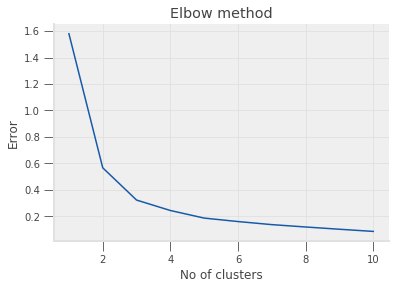

In [51]:
# Checking for most efficient choice of cluster by choosing cluster level = 5

x = pct.loc[:, ['pct_change_rent','pct_change_income']].values
kmeans5 = KMeans(n_clusters=5)
y_kmeans5 = kmeans5.fit_predict(x)
print(y_kmeans5)

kmeans5.cluster_centers_

Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

* The elbow method is used to visually ascribe the optimal number of clusters that occurs when the total within-cluster sum of squares improvement from adding additional clusters levels off. The figure above shows a small drop-off in WSS accuracy between k of 2 and 4. 

[2 1 1 1 1 0 0 2 0 0 1 0 1 0 2 1 0 1 0 0 0 2 0 0 2 0 2 2 0 0 0 0 2 2 1 2 2
 2 0 2 2 0 1 0 1 1 0 2 2 2 2 0 2 1 1]


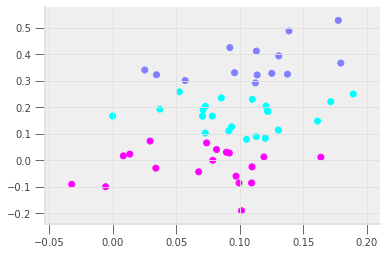

In [61]:
# Choose cluster = 3, creating clusters

iris = datasets.load_iris()
X = iris.data
y = iris.target

kmeans3 = KMeans(n_clusters=3)
y_kmeans3 = kmeans3.fit_predict(x)
print(y_kmeans3)
kmeans3.cluster_centers_

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans3, cmap='cool')

* ### Linking the K-means cluster back to our dataset

In [62]:
kmeans3.labels_

array([2, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 0,
       1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1], dtype=int32)

In [66]:
# Finding which sub-borough codes lie in which cluster to classify sub-boroughs 
# as gentrified status or not

mydict = {i: np.where(kmeans3.labels_ == i)[0] for i in range(kmeans3.n_clusters)}
mydict

{0: array([ 5,  6,  8,  9, 11, 13, 16, 18, 19, 20, 22, 23, 25, 28, 29, 30, 31,
        38, 41, 43, 46, 51]),
 1: array([ 1,  2,  3,  4, 10, 12, 15, 17, 34, 42, 44, 45, 53, 54]),
 2: array([ 0,  7, 14, 21, 24, 26, 27, 32, 33, 35, 36, 37, 39, 40, 47, 48, 49,
        50, 52])}

In [67]:
pct_changes.head()

,Borough,Sub-borough area,pct_change_rent,pct_change_income
0,1,1,0.033933,-0.029619
1,1,2,0.112235,0.291866
2,1,3,0.113636,0.321850
3,1,4,0.095833,0.330288
4,1,5,0.056967,0.300767


In [69]:
# Colour coding the sub-boroughs based on K-Means results

pct_color = pd.read_excel('./pct_changes.xlsx')
def highlight_cluster(s,column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] = 0
    return ['background-color: purple' if is_max.any() else '' for v in is_max]
 
def highlight_cluster0(s):
    if s.cluster == 0.0:
        return ['background-color: deeppink']*5
    elif s.cluster == 1.0:
        return ['background-color: deepskyblue']*5
    elif s.cluster == 2.0:
        return ['background-color: darkblue']*5
    
pct_color_v = pct_color.style.apply(highlight_cluster0, axis=1).set_properties(**{'color': 'white','border-color': 'white'})
pct_color_v

,Borough,Sub-borough area,pct_change_rent,pct_change_income,cluster
0,1,1,0.033933,-0.029619,0
1,1,2,0.112235,0.291866,2
2,1,3,0.113636,0.321850,2
3,1,4,0.095833,0.330288,2
4,1,5,0.056967,0.300767,2
5,1,6,0.109787,0.229885,1
6,1,7,0.078378,0.166667,1
7,1,8,0.013462,0.023286,0
8,1,9,0.072917,0.203209,1
9,1,10,0.000000,0.166667,1


## Gentrification Geo-spatial analysis 

In order to be able to mark the sub-boroughs by cluster colour on a map, I had to manually add the latitude and longitude on excel. 

In [70]:
gent_map = pd.read_csv('./pct_changes.csv')
gent_map = gent_map.drop(['Unnamed: 5'], axis=1)
gent_map.head()

,Borough,Sub-borough area,pct_change_rent,pct_change_income,cluster,Borough Name,Sub-borough Name,Latitude,Longitude
0,1,1,0.033933,-0.029619,0,Bronx,Mott Haven/ Hunts Point,40.809700,-73.915620
1,1,2,0.112235,0.291866,2,Bronx,Morrisania/ East Tremont,40.828290,-73.907040
2,1,3,0.113636,0.321850,2,Bronx,Highbridge / South Concourse,40.846055,-73.929733
3,1,4,0.095833,0.330288,2,Bronx,University Heights / Fordham,40.861475,-73.890544
4,1,5,0.056967,0.300767,2,Bronx,Kingsbridge Heights / Mosholu,40.879732,-73.884670


In [72]:
# Using latitude longitude, mapping gentrification using folium

folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="CartoDB dark_matter",
                        width='90%')

for index, row in gent_map.iterrows():
    
    gentrification_factor = (row["pct_change_income"]+row["pct_change_rent"])
    
    radius = (gentrification_factor)*2
    
    popup_text = """{}<br>
                Change in Income: {}<br> 
                Change in Rent: {}<br>
                gentrification value: {}"""
    
    popup_text = popup_text.format(row["Borough"],
                               row["pct_change_income"],
                               row["pct_change_rent"],
                               gentrification_factor)
    
    if gentrification_factor<0.63 and gentrification_factor>0.357005:
        color="#ADD8E6" # light blue
    else:
        if gentrification_factor<0.44 and gentrification_factor>0.18:
            color="#0000FF" # blue
        else:
            color="#FF1493" # deep pink
    
    folium.CircleMarker(location=(row["Latitude"],
                                  row["Longitude"]),
                        radius=radius,
                        color=color,
                        popup=popup_text,
                        fill=True).add_to(folium_map)
folium_map

### Analysis:

* In order to classify them by colour, I had to manually observe the range of each cluster. We can see that the range of the gentrification factor for the highest cluster (2) which is dark blue, represents the gentrified neighborhoods of New York since they had the highest percent changes in home and rent value. On analyzing the map, one can conclude that **Bronx** and **Brooklyn** are two boroughs that have the **most gentrified neighborhoods.**

* The lighter blue circles mark the neighborhoods that are currently **gentrifying** since they had a modest percent change in housing units. Some neighborhoods around **Queens**, **Brooklyn** and **Manhattan** seem to be in a gentrifying phase.

* ### Racial Profiling by Sub-borough

In [73]:
race2014 = pd.read_csv('./race2014.csv')
pct_change = pd.read_csv('./pct_changes.csv')
merge1 = pd.merge(race2014, pct_change, on=["Borough", "Sub-borough area"])

race2017 = pd.read_csv('./race2017.csv')
merge2 = pd.merge(race2017, pct_change, on=["Borough", "Sub-borough area"])

race_2014 = merge1[['Sub-borough Name', 'Race_count']]
race_2017 = merge2[['Sub-borough Name', 'Race_count']]

race_2014 = race_2014.rename(columns={"Race_count": "Race_count2014"})
race_2017 = race_2017.rename(columns={"Race_count": "Race_count2017"})
merge3 = pd.merge(race_2014, race_2017, on=["Sub-borough Name"])

TypeError: cannot unpack non-iterable AxesSubplot object

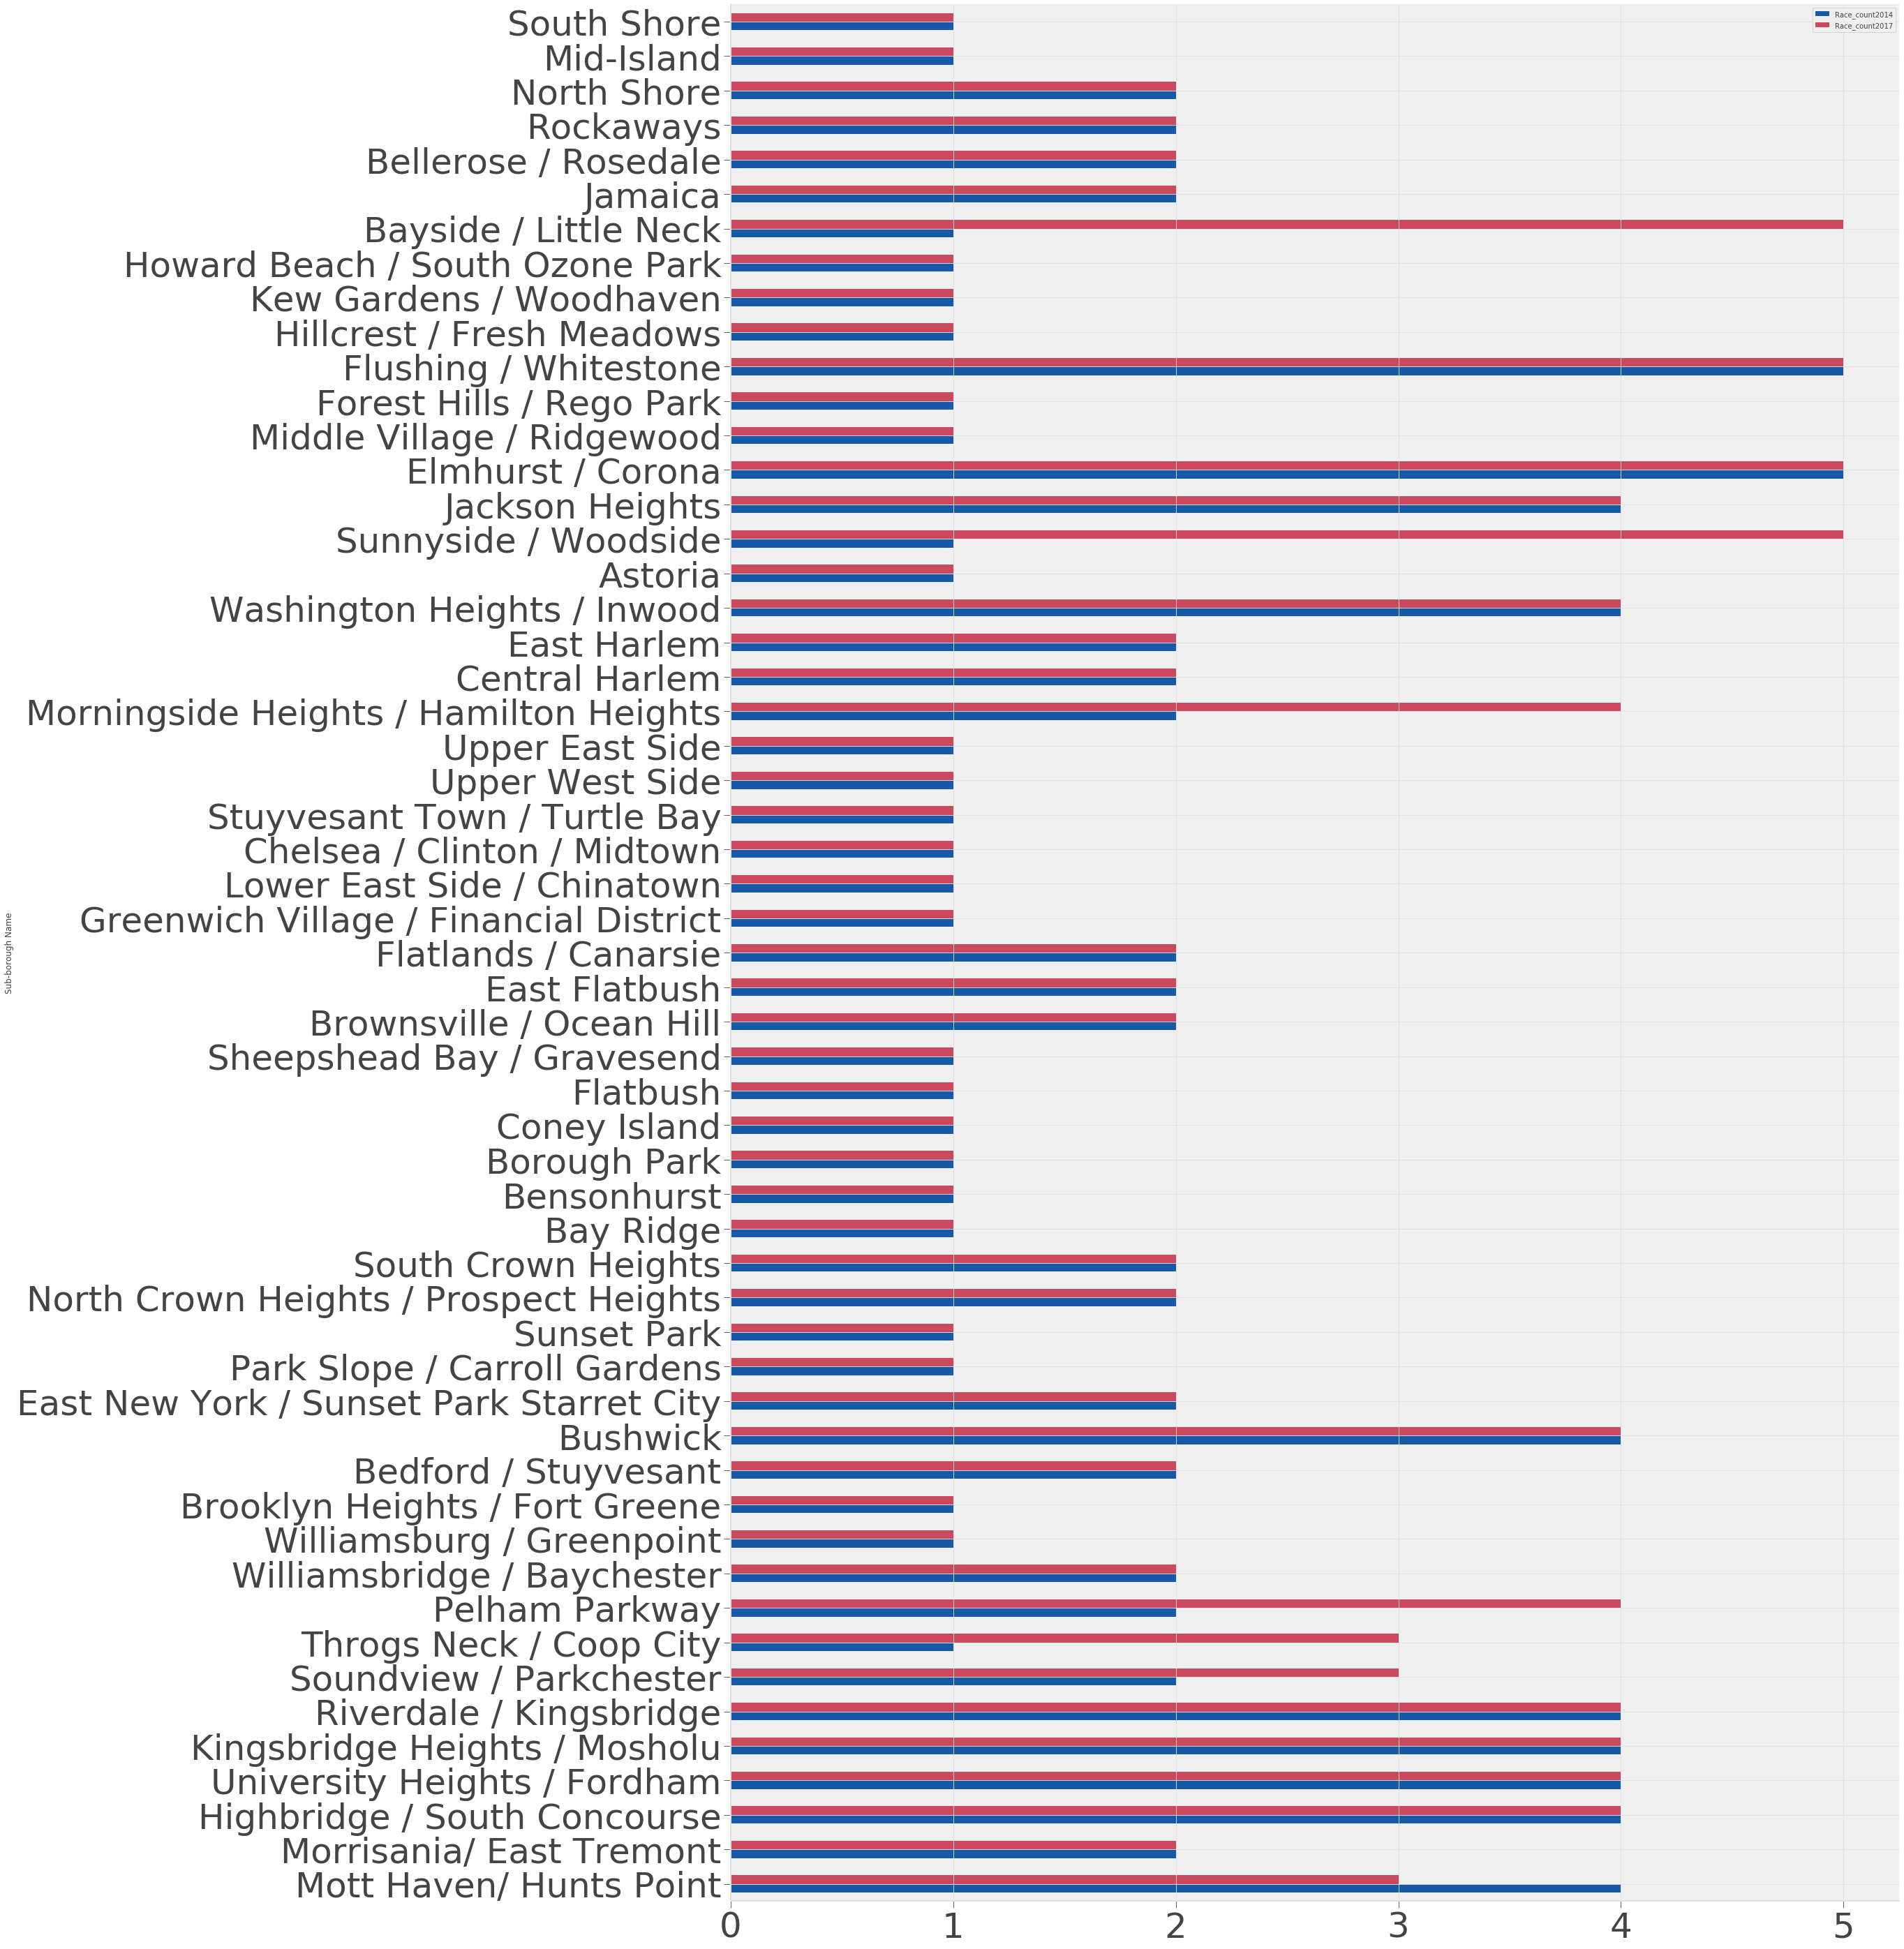

In [74]:
race_bar = merge3.set_index('Sub-borough Name')
fig, ax = race_bar.plot.barh(fontsize=50, figsize=(30, 50))

**Bronx**, **Queens** and **Manhattan** seem to have had a change in the race of majority population in the respective neighbourhoods. Parkchester and Pelham Parkway in **Bronx** used to be inhabited by a majority of Black or African American individuals but by 2017, the dynamic changed to American Indian or Chinese indicating cultural displacement. 

## AirBnb Geo-Spatial Analysis

In [76]:
# Loading AirBnb 2014 and 2017 data

airbnb2014 = pd.read_csv("./AirBnb2014.csv")
print('We have', airbnb2014.room_id.nunique(), 'unique listings in New York in 2014.')

airbnb2017 = pd.read_csv("./AirBnb2017.csv")
print('We have', airbnb2017.room_id.nunique(), 'unique listings in New York in 2017.')

We have 25405 unique listings in New York in 2014.
We have 41245 unique listings in New York in 2017.


In [77]:
# Finding mean price for every neighborhood in 2014 and 2017

subset_2014 = airbnb2014.groupby(['borough','neighborhood','latitude','longitude','reviews']).agg({'price': ['mean']})
subset_2014.columns = ['mean_price']
subset_2014 = subset_2014.reset_index()
subset_2014['year'] = '2014'

subset_2017 = airbnb2017.groupby(['borough','neighborhood','latitude','longitude','reviews']).agg({'price': ['mean']})
subset_2017.columns = ['mean_price']
subset_2017 = subset_2017.reset_index()
subset_2017['year'] = '2017'

In [79]:
# Creating a final listings dataset with longitude and latitude

locations = subset_2014.groupby("neighborhood").first()
# selecting only the three columns I am interested in
locations = locations.loc[:, ["borough",
                              "latitude",
                              "longitude"]]

borough_2014 = subset_2014.groupby("neighborhood").count()
borough_2014 = borough_2014.iloc[:,[0]]
borough_2014.columns= ["Listings2014"]


borough_2017 = subset_2017.groupby("neighborhood").count()
borough_2017 = borough_2017.iloc[:,[0]]
borough_2017.columns= ["Listings2017"]

listing_counts = borough_2014.join(locations).join(borough_2017)
listing_counts.head()

,Listings2014,borough,latitude,longitude,Listings2017
neighborhood,,,,,
Allerton,14,Bronx,40.858397,-73.869686,20.0
Arverne,8,Queens,40.586906,-73.799689,62.0
Astoria,385,Queens,40.754248,-73.915096,833.0
Battery Park City,109,Manhattan,40.704044,-74.016572,65.0
Bay Ridge,51,Brooklyn,40.622239,-74.026293,103.0


* I now have the final table with number of listings from 2014 and 2017. I will use _net listings_ to reflect neighborhoods that saw a growth/reduction in listings. The **tangerine circles** on the folium map reflect those neighborhoods that went through the an **increase** in listings, whereas **teal** circles represent areas with a **decrease** in listings. **The size of circles represents the magnitude of change.**

In [82]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=10,
                        tiles="CartoDB dark_matter",
                        width='100%')
marker = folium.CircleMarker(location=[40.738, -73.98])
marker.add_to(folium_map)

for index, row in listing_counts.iterrows():
    
    net_listings = (row["Listings2017"]-row["Listings2014"])
    
    radius = net_listings/20
    
    popup_text = """{}<br>
                2014 Listings: {}<br> 
                2017 Listings: {}<br>
                net listings: {}"""
    
    popup_text = popup_text.format(row["borough"],
                               row["Listings2014"],
                               row["Listings2017"],
                               net_listings)
    
    if net_listings>0:
        color="#E37222" # tangerine
    else:
        color="#0A8A9F" # teal
    
    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius=radius,
                        color=color,
                        popup=popup_text,
                        fill=True).add_to(folium_map)

In [81]:
folium_map

* Now, to see a similar trend in price we have to find the mean price for each neighborhood. This will be represented through a heat map which will show concentration in areas that had the most change in price.

In [95]:
locations_pct = subset_2014.groupby("neighborhood").first()
locations_pct = locations.loc[:, ["borough", "latitude", "longitude"]]

price2014 = subset_2014.sort_values(by=['borough'])

airbnb_price_2014 = price2014.groupby(['neighborhood']).agg({'mean_price': ['mean']})
airbnb_price_2014.columns = ['price_mean_2014']

price2017 = subset_2017.sort_values(by=['borough'])

airbnb_price_2017 = price2017.groupby(['neighborhood']).agg({'mean_price': ['mean']})
airbnb_price_2017.columns = ['price_mean_2017']

price_pct = airbnb_price_2014.join(locations_pct).join(airbnb_price_2017)

map_price = folium.Map(location=[40.738, -73.98],
                        zoom_start=12,
                        width='100%')

heat_data = [[row['latitude'],row['longitude']] for index, row in price_pct.iterrows()]
HeatMap(heat_data).add_to(map_price)

price_pct.head()

,price_mean_2014,borough,latitude,longitude,price_mean_2017
neighborhood,,,,,
Allerton,72.357143,Bronx,40.858397,-73.869686,67.000000
Arverne,110.125000,Queens,40.586906,-73.799689,140.306452
Astoria,122.958442,Queens,40.754248,-73.915096,93.397359
Battery Park City,375.339450,Manhattan,40.704044,-74.016572,218.015385
Bay Ridge,98.235294,Brooklyn,40.622239,-74.026293,76.145631


In [96]:
map_price

* On analyzing both maps, we can see that **Bronx, Manhattan and Brooklyn** saw the most changes in price and listings. 

## Conclusion

Based on the k-means clustering analysis on gentrification, it was clear that Bronx and Brooklyn are the most gentrified neighbourhoods over the period 2014-2017. Visualization fo the airbnb data shows that there was a significant **increase in prices and listing in Bronx and Brooklyn** during this same period. Therefore, it can be concluded that gentrification is **poitively correlated** with the presence and expansion of airbnb. **Although causality cannot be established without further research, it is clear that airbnb and gentrification move hand-in-hand, at least in New York.**